In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import pickle
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import normalize

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import make_classification

from sklearn import tree

## Overview

In this notebook, we will focus on `classification` methods (i.e. the target we want to predict is a categorical variable) and use cross validation methods to estimate the test error.
* Introduce to new dataset: Granta
* K-Nearest-Neighbor(KNN) Classification
  - Evaluate the test error by train-test-splitting
  - Find the K minimize the test error
  - Evaluate the test error by K-fold cross validation
* Support Vector Machine(SVM) binary classification 
  - Evaluate the test error by train-test-splitting
  - Tune the parameter C
* Decision Trees
  - Evaluate the test error by train-test-splitting
  - Explore the maximum depth of tree
  - Evaluate the test error by K-fold cross validation

## Introduce Granta dataset

Granta is a database that contains many commercial materials with their experimentally measured properties. In this notebook we will work with only a small subset (~400) of materials from Granta. 

There are many `numerical` properties such as: Electrical conductivity, thermal conductivity, etc, which are given by numbers. 
while many properties are `categorical`, such as magnetic type (Magnetic vs non-magnetic), tolerance to strong acids (acceptable, excellent, unacceptable, limited use), etc, which are given by labels/categories. 

In [4]:
grantadata = pickle.load(open("grantadata.p","rb"))
grantadata.set_index('id',inplace=True)

grantadata.keys()

Index(['Acoustic velocity (in/s)', 'Base material', 'Bulk modulus (10^6 psi)',
       'CO2 footprint, primary production (lb/lb)',
       'Compressive strength (ksi)', 'Density (lb/in^3)',
       'Ductility index (mil)',
       'Elastic stored energy (springs) (ft.lbf/in^3)',
       'Electrical conductivity (%IACS)', 'Electrical resistivity (μohm.in)',
       'Embodied energy, primary production (BTU/lb)',
       'Fatigue strength at 10^7 cycles (ksi)', 'Flammability',
       'Flexural modulus (10^6 psi)',
       'Flexural strength (modulus of rupture) (ksi)',
       'Fracture toughness (ksi.in^0.5)', 'Hardness - Vickers (HV)',
       'Latent heat of fusion (BTU/lb)', 'Magnetic type', 'Material family',
       'Maximum service temperature (°F)',
       'Mechanical loss coefficient (tan delta)', 'Melting point (°F)',
       'Minimum service temperature (°F)', 'Organic solvents',
       'Oxidation at 500C', 'Poisson's ratio', 'Price (USD/lb)',
       'Price per unit volume (USD/ft^3)',
 

In [5]:
grantadata.head()

,Acoustic velocity (in/s),Base material,Bulk modulus (10^6 psi),"CO2 footprint, primary production (lb/lb)",Compressive strength (ksi),Density (lb/in^3),Ductility index (mil),Elastic stored energy (springs) (ft.lbf/in^3),Electrical conductivity (%IACS),Electrical resistivity (μohm.in),...,Transparency,UV radiation (sunlight),Warmth to touch,Water (fresh),Water (salt),Weak acids,Weak alkalis,Yield strength (elastic limit) (ksi),Young's modulus (10^6 psi),name
id,,,,,,,,,,,,,,,,,,,,,
0,300000,Carbide,35.55,6.365,1210,0.2405,2.56e-07,10.895,2.155,31.5,...,Opaque,Excellent,13.7,Excellent,Excellent,Excellent,Excellent,121,56.3,Zirconium carbide
1,48800,Oxide,0.1815,8.735,0.276,0.02925,0.00126,0.008345,9.46e-17,2.167e+18,...,Opaque,Excellent,319.5,Excellent,Excellent,Excellent,Excellent,0.1815,0.1815,Zirconia with magnesia foam (partly stabilized...
2,42850,Oxide,0.1305,8.735,0.1745,0.02675,0.0012,0.0103,9.46e-17,2.167e+18,...,Opaque,Excellent,329,Excellent,Excellent,Excellent,Excellent,0.167,0.1305,Zirconia with calcia foam (fully stabilized)(0...
3,56700,Oxide,0.1885,4.86,0.25,0.0226,0.0011025,0.00869,9.46e-16,2.167e+17,...,Opaque,Excellent,237,Excellent,Excellent,Excellent,Excellent,0.1885,0.1885,Zirconia mullite alumina foam (0.63)
4,50000,Oxide,0.3045,8.735,0.841,0.047,0.00431,0.003745,9.46e-16,2.167e+17,...,Opaque,Excellent,242.5,Excellent,Excellent,Excellent,Excellent,0.1595,0.3045,Zirconia foam (partly stabilized)(1.28)


In [6]:
grantadata.describe()

,Acoustic velocity (in/s),Base material,Bulk modulus (10^6 psi),"CO2 footprint, primary production (lb/lb)",Compressive strength (ksi),Density (lb/in^3),Ductility index (mil),Elastic stored energy (springs) (ft.lbf/in^3),Electrical conductivity (%IACS),Electrical resistivity (μohm.in),...,Transparency,UV radiation (sunlight),Warmth to touch,Water (fresh),Water (salt),Weak acids,Weak alkalis,Yield strength (elastic limit) (ksi),Young's modulus (10^6 psi),name
count,390.0,390,390.0,390.00,390.0,390.000,390.000000,390.0,390.000,390.00,...,390,390,390.00,390,390,390,390,390.00,390.00,390
unique,270.0,56,294.0,230.00,300.0,268.000,348.000000,371.0,255.000,247.00,...,3,1,327.00,4,4,4,4,290.00,263.00,390
top,255500.0,Carbide,55.6,2.81,290.5,0.323,0.000004,43.8,8.495,8.66,...,Opaque,Excellent,5.89,Excellent,Excellent,Excellent,Excellent,29.05,14.55,"Osmium, commercial purity, hard"
freq,7.0,80,5.0,21.00,9.0,9.000,3.000000,3.0,26.000,26.00,...,384,390,4.00,352,281,298,279,9.00,7.00,1


We will use the Young's modulus, melting point (numerical properties) to predict the tolerance of oxidation at 500C (categorical property).

We can observe the distribution of these 3 properties in the below scatter plot.


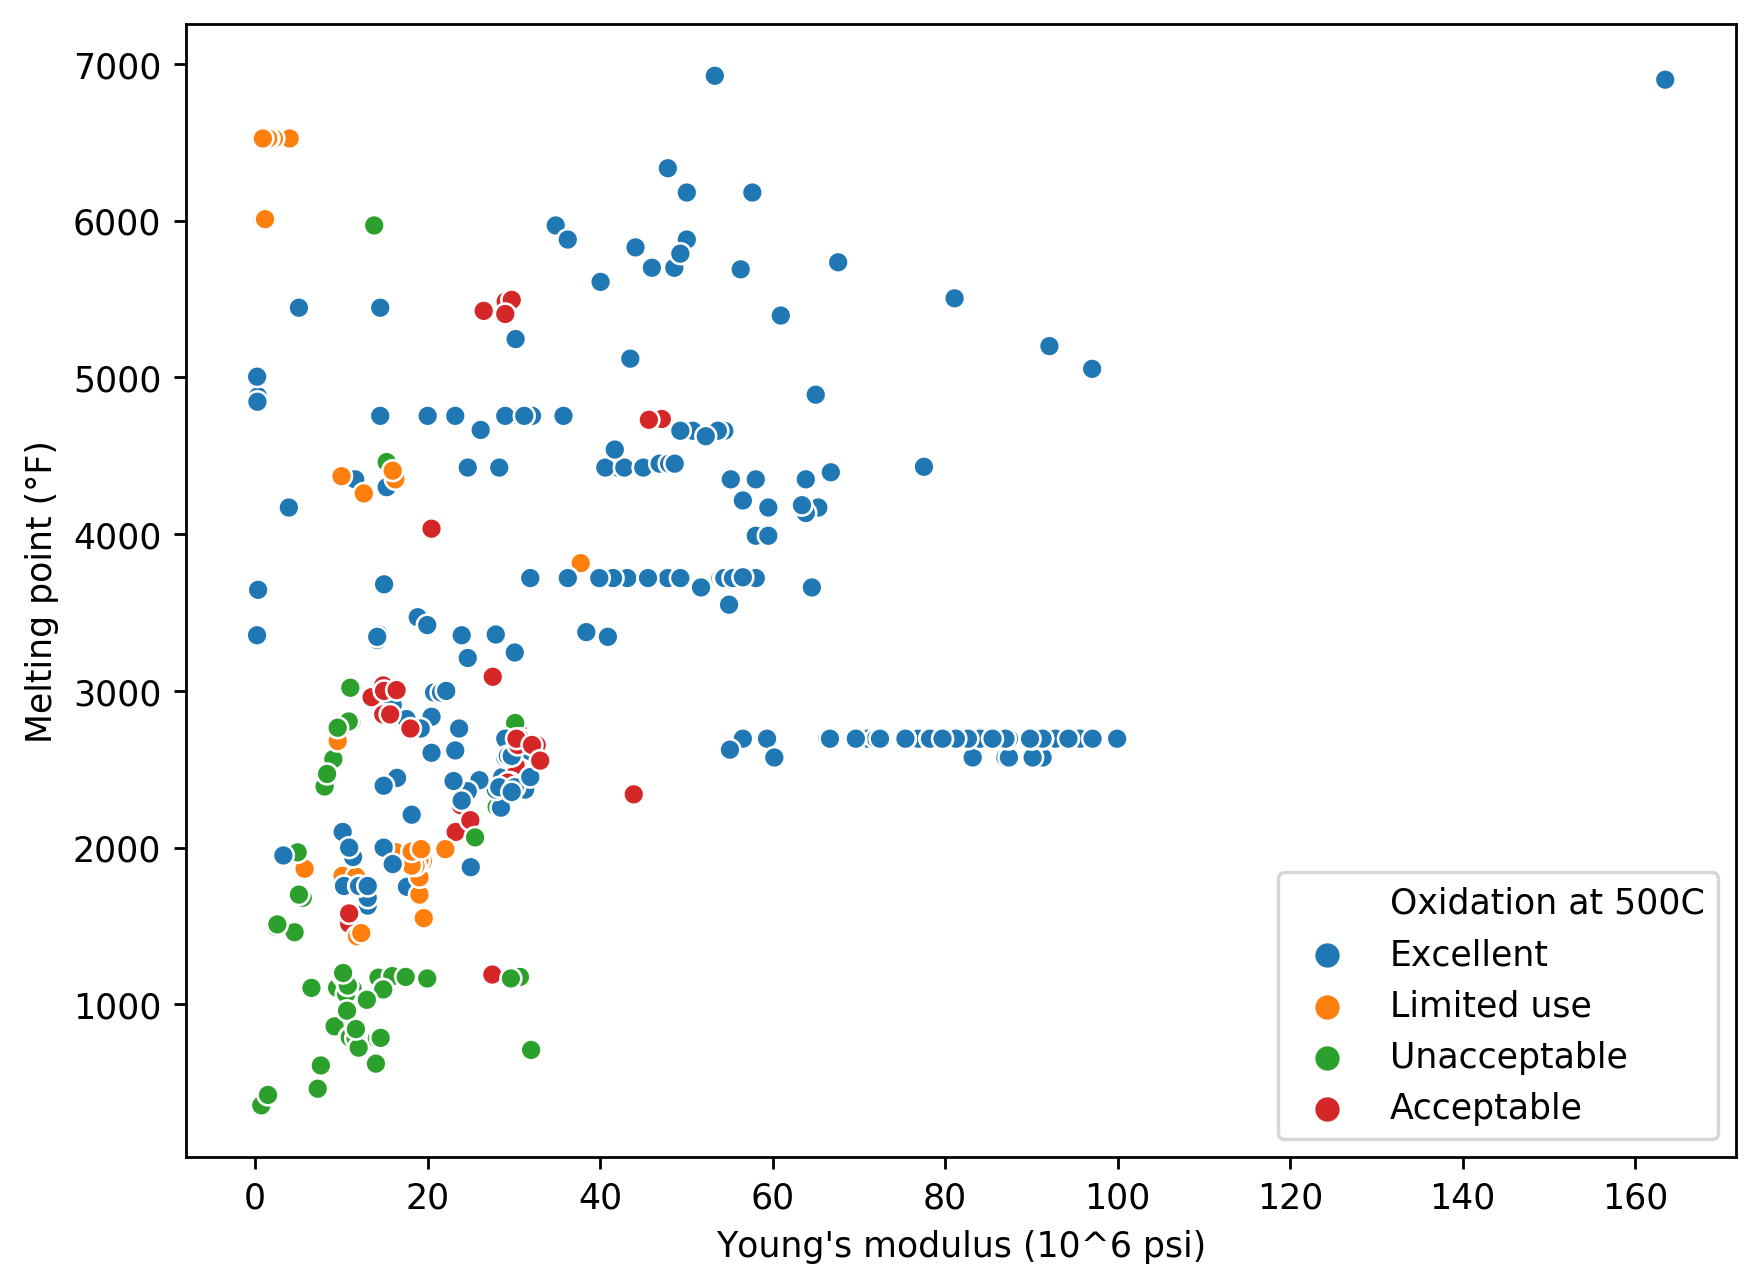

In [7]:
plt.figure(figsize=(8,6),dpi=250)

# scatter plot with Seaborn, the parameter 'hue' indicates the points be colorcoded with their category
sns.scatterplot("Young's modulus (10^6 psi)",'Melting point (°F)',data=grantadata,hue='Oxidation at 500C')
#plt.xlim(0,100)
plt.show()

## K-Nearest Neighbor (KNN) Classification

#### Recap of KNN method

The predicted category of a given data point will be decided by the most common category within its K nearest neighbors in the training dataset. For example, in the case shown below, the category of the given point (the green one with question mark) is predicted to be red if we consider its 3 nearest neighbors (i.e. k = 3), or it is predicted to be blue if we consider its 5 nearest neighbors (i.e. k = 5).

<a title="Antti Ajanki AnAj, CC BY-SA 3.0 &lt;http://creativecommons.org/licenses/by-sa/3.0/&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:KnnClassification.svg"><img width="256" alt="KnnClassification" src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/256px-KnnClassification.svg.png"></a>

#### Preprocessing

* Firstly, we normalize our features by: $ X_i = \frac{X_i}{\sqrt{\sum_j^n X_{ij} ^2}}$ . 
$i,j$ refer to the $j$-th sample in the $i$-th feature.

This step is important because the k neighbors are determined regarding their Euclidean distance in the space. If the value of different features vary in magnitudes, we would see those features with higher magnitude dominate over the others. Thus we use normalization to convert our Young's modulus and melting point values into roughly same range.

* In order to estimate the test error by train test splitting, we split the normalized dataset into 20% testing data and 80% training data.

In [8]:
x_knn = grantadata[["Young's modulus (10^6 psi)",'Melting point (°F)']].astype(float)
y_knn = grantadata['Oxidation at 500C']

x_knn_norm = pd.DataFrame(data=normalize(x_knn,axis=0),columns=x_knn.columns)

x_trainknn, x_testknn, y_trainknn, y_testknn = train_test_split(x_knn_norm,y_knn,test_size=0.2,random_state=55)

Check the result of normalization

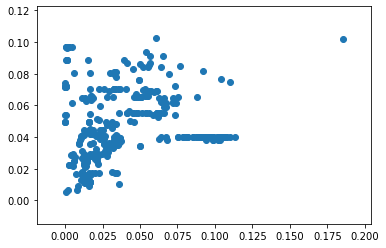

In [9]:
plt.scatter(x_knn_norm["Young's modulus (10^6 psi)"], x_knn_norm['Melting point (°F)'])

#### Train KNN and get test error

* Firstly define the knn_model `object`
* use `fit` method to train the knn model with our training dataset. 
* use `predict` method to get the prediction result on a given dataset
* use `score` method to get the accuracy of predicition on a given dataset. The error would be (1-accuracy)

Here we give an example of k=3

In [10]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x_trainknn,y_trainknn)

y_predictknn = knn_model.predict(x_testknn) 

#getting test accuracy
knn_model.score(x_testknn,y_testknn)

0.8717948717948718

We plot the training data (shown as dot) and the testing data (shown as cross) below, with the color of training data points representing its real category and the color of testing data points representing its predicted category.

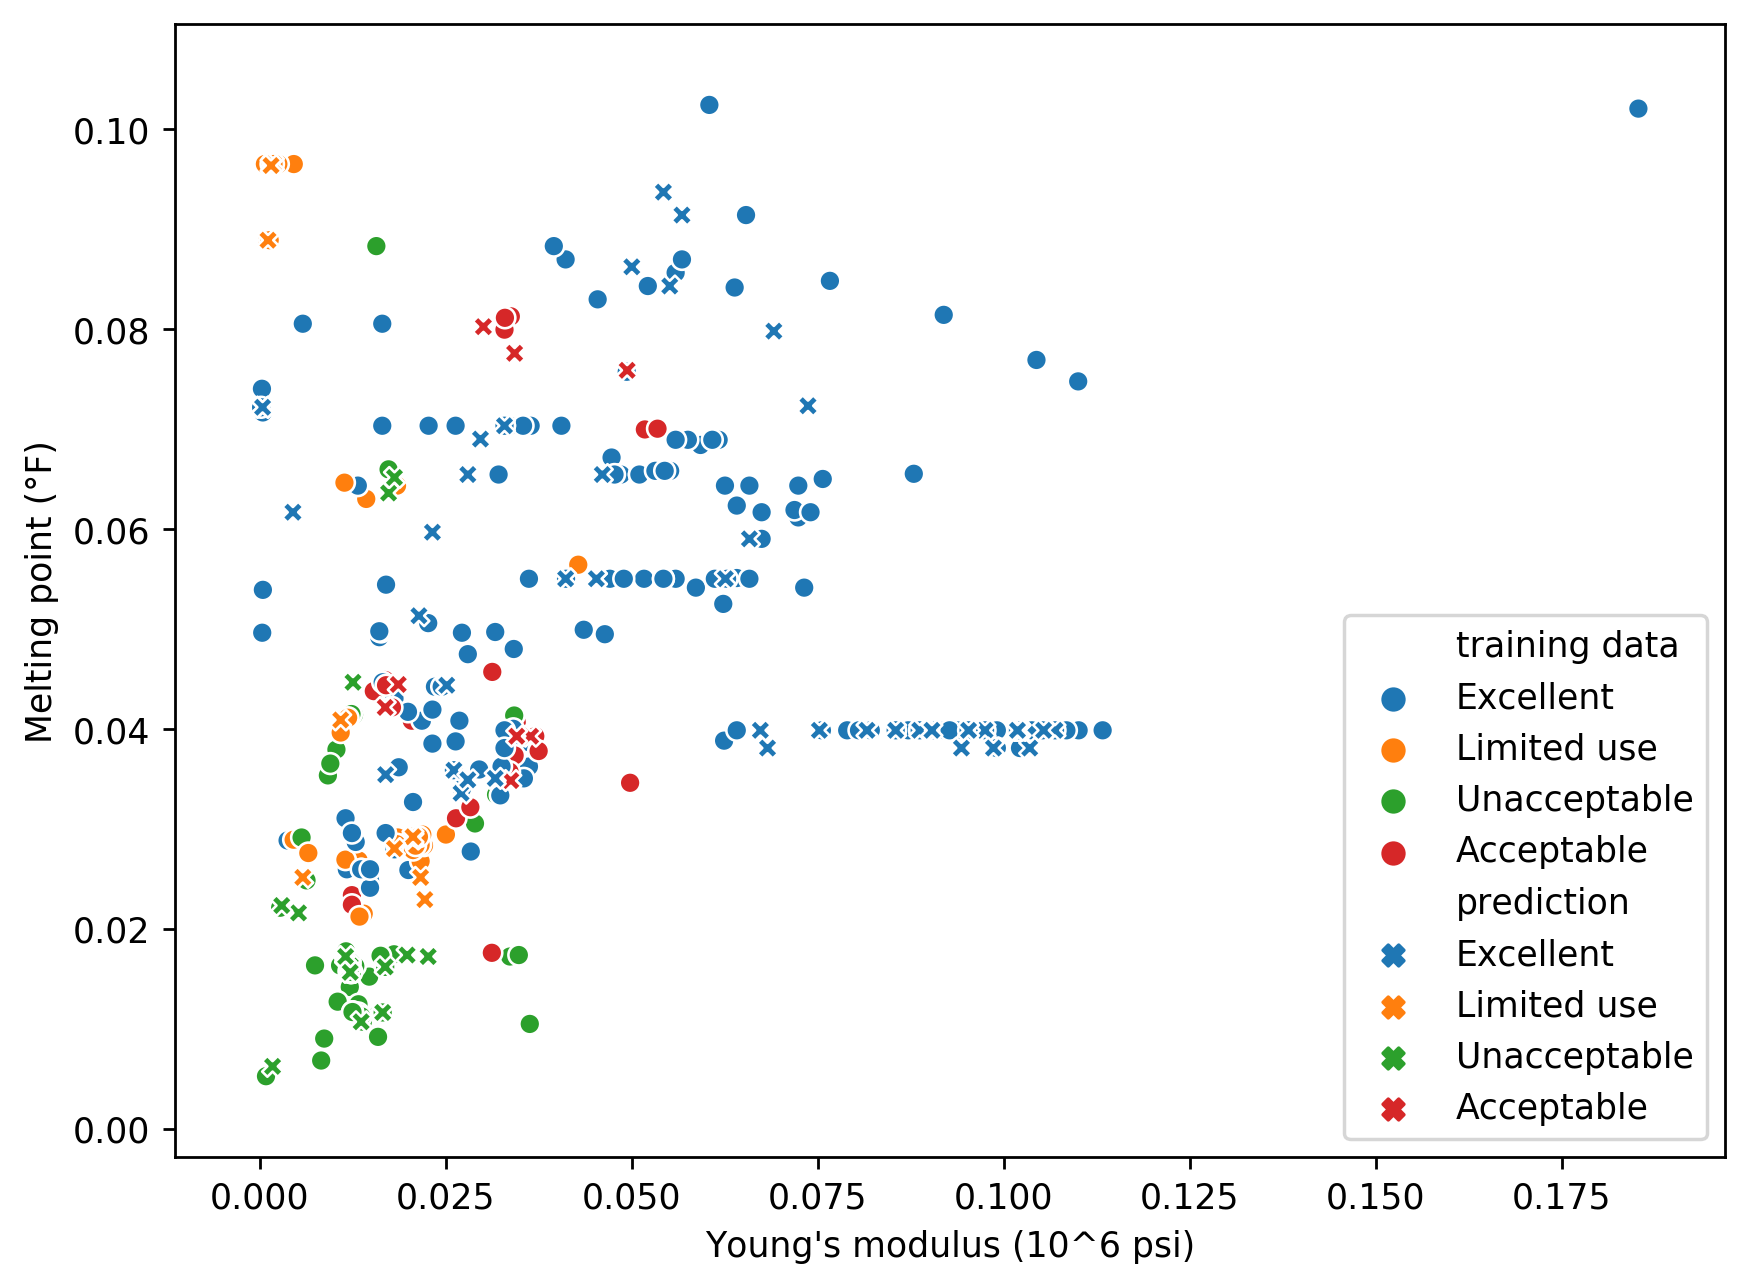

In [11]:
plt.figure(figsize=(8,6),dpi=250)

#pack the x and y into pandas dataframe so we can easily plot them with seaborn
knnpredict_results = x_testknn.copy()
knnpredict_results['prediction'] = y_predictknn
knntrain_results = x_trainknn.copy()
knntrain_results['training data'] = y_trainknn.values 

sns.scatterplot("Young's modulus (10^6 psi)",'Melting point (°F)',data=knntrain_results,
                hue='training data',hue_order=['Excellent', 'Limited use', 'Unacceptable','Acceptable'])

sns.scatterplot("Young's modulus (10^6 psi)",'Melting point (°F)',data=knnpredict_results,
                hue='prediction',style='prediction',markers=['X']*4,hue_order=['Excellent', 'Limited use','Unacceptable', 'Acceptable'])
plt.show()

### Exercise 1
* What will be the training error for a KNN classifier when K=1? Please explain

The error will be 0 because the closest point will be itself so it will always pick itself and won't make any mistakes.

### Exercise 2
* Please compute the test and training error of KNN model with K value ranges from 1 to 30, and make a plot of the variation of test and training error as a function of K value.
What is the optimal value of K in terms of the test error estimated by this testing dataset we use?

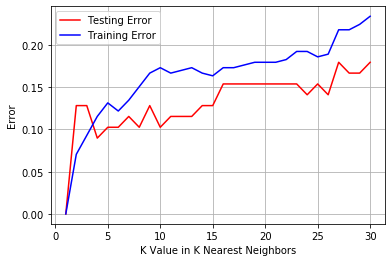

In [12]:
k_list = np.arange(1,31,1)
train = [0]*len(k_list)
test = [0]*len(k_list)
for i in range (1,30):
    knn_model_evaluate = KNeighborsClassifier(n_neighbors = k_list[i])
    knn_model_evaluate.fit(x_trainknn,y_trainknn)
    train[i] = 1-knn_model_evaluate.score(x_trainknn, y_trainknn)
    test[i] = 1-knn_model_evaluate.score(x_testknn, y_testknn)
    
plt.plot(k_list,test, label = 'Testing Error', c = 'r')
plt.plot(k_list,train,label = 'Training Error', c='b')
plt.xlabel('K Value in K Nearest Neighbors')
plt.ylabel('Error')
plt.legend()
plt.grid()

## Evaluate KNN test error by K-fold cross validation

#### Recap of k-fold cross validation

We divide the dataset into k groups (note that this is not the k in KNN), or folds. The first fold is treated as a testing set, and the model is fit on the remaining (k − 1) folds. The test error, is then computed on the datapoints in the held-out fold. This procedure is repeated k interations; each interation, a different fold is treated as a testing dataset. This process results in k estimates of the test error. And the test error estimated by K-fold cross-validation is the average of these k estimates.

<a title="Gufosowa, CC BY-SA 4.0 &lt;https://creativecommons.org/licenses/by-sa/4.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:K-fold_cross_validation_EN.svg"><img width="512" alt="K-fold cross validation EN" src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/K-fold_cross_validation_EN.svg/512px-K-fold_cross_validation_EN.svg.png"></a>


We use the code below to perform a 5-fold cross-validation on our knn model with k=3. `KFold` creates an object with number of folds defined by parameter `n_splits`. `KFold.split()` generates 5 sets of training data index and testing data index, corresponding to the 5 interations of train-test splitting in the 5-fold cross-validation.

In [13]:
kf = KFold(n_splits=5,shuffle=True,random_state=22)
test_error_kfold = 0
knn_model_evaluate = KNeighborsClassifier(n_neighbors=3)

for train_index, test_index in kf.split(x_knn_norm):
    knn_model_evaluate.fit(x_knn_norm.values[train_index],y_knn[train_index])
    test_error_kfold += 1-knn_model_evaluate.score(x_knn_norm.values[test_index],y_knn[test_index])
    
test_error_kfold /= 5

#this is the test error estimated by k-fold
test_error_kfold    

0.16666666666666669

### Exercise 3
* Please do a 4-fold cross-validation on KNN model with K value ranges from 1 to 30, and make a plot showing the variation of training error, test error estimated by train-test splitting (you already obtained earlier) and the test error estimated by 4-fold cross-validation. What can you observe from the plot?

Text(0, 0.5, 'Error')

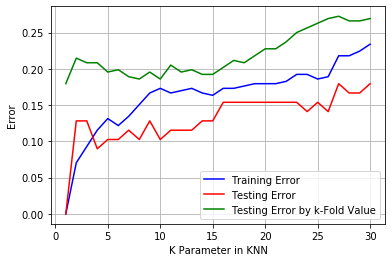

In [14]:
kf_ex = KFold(n_splits=4,shuffle=True,random_state=33)
test_error_kfold_ex=[0]*len(k_list)

for i in range(len(k_list)):
    for train_index, test_index in kf.split(x_knn_norm):
        knn_model_evaluate_ex = KNeighborsClassifier(n_neighbors = k_list[i])
        knn_model_evaluate_ex.fit(x_knn_norm.values[train_index], y_knn[train_index])
        knn_model_evaluate.fit(x_knn_norm.values[train_index],y_knn[train_index])
        test_error_kfold_ex[i] += 1-knn_model_evaluate_ex.score(x_knn_norm.values[test_index],y_knn[test_index])
    test_error_kfold_ex[i] /= 4   
plt.plot(k_list,train, label='Training Error', c='b')
plt.plot(k_list,test,label = 'Testing Error', c='r')
plt.plot(k_list, test_error_kfold_ex, label ='Testing Error by k-Fold Value', c='g')
plt.legend()
plt.grid()
plt.xlabel('K Parameter in KNN')
plt.ylabel('Error')

## Support Vector Machine (SVM)

#### SVM method

Assuming we have some data points belonging to two categories as shown below, the main idea of SVM method is to find a line that seperates the two classes while maxmize the margin (we can calculate the perpendicular distance from each training data points to the line, the smallest such distance is the margin). In the picture below, H1 does not separate the classes. H2 does, but only with a small margin. H3 separates them with the maximal margin.

<a title="User:ZackWeinberg, based on PNG version by User:Cyc, CC BY-SA 3.0 &lt;https://creativecommons.org/licenses/by-sa/3.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Svm_separating_hyperplanes_(SVG).svg"><img width="512" alt="Svm separating hyperplanes (SVG)" src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Svm_separating_hyperplanes_%28SVG%29.svg/512px-Svm_separating_hyperplanes_%28SVG%29.svg.png"></a>

For simplicity, we only consider binary classification here. You can refer to the Chapter 9.4 of this book (http://faculty.marshall.usc.edu/gareth-james/ISL/) to learn the case with more than two categories.

Here we combine the 'Acceptable', 'Limited use', 'Unacceptable' into one new category called 'Other', to convert this classification problem into a binary one.

In [34]:
x_svm_norm = x_knn_norm.copy()
y_svm = grantadata['Oxidation at 500C'].copy()

for i in range(len(grantadata)):
    if grantadata['Oxidation at 500C'][i] in ['Acceptable', 'Limited use', 'Unacceptable']:
        y_svm[i] = 'Other'

#### Train SVM and get test error

In [35]:
x_trainsvm, x_testsvm, y_trainsvm, y_testsvm = train_test_split(x_svm_norm,y_svm,test_size=0.2,
                                                                random_state=55)

svm_model = SVC(kernel='linear', C=20)

svm_model.fit(x_trainsvm, y_trainsvm)
y_predictsvm = svm_model.predict(x_testsvm)

#test error
1 - svm_model.score(x_testsvm, y_testsvm)

0.2435897435897436

We plot the training data (shown as dot) and the testing data (shown as cross), with the color of training data points representing its real category and the color of testing data points representing its predicted category. A decision boundary (a line assumed to seperate the two categories, the datapoints on same side of the line will all be predicted to be the same category) found by SVM is also shown.

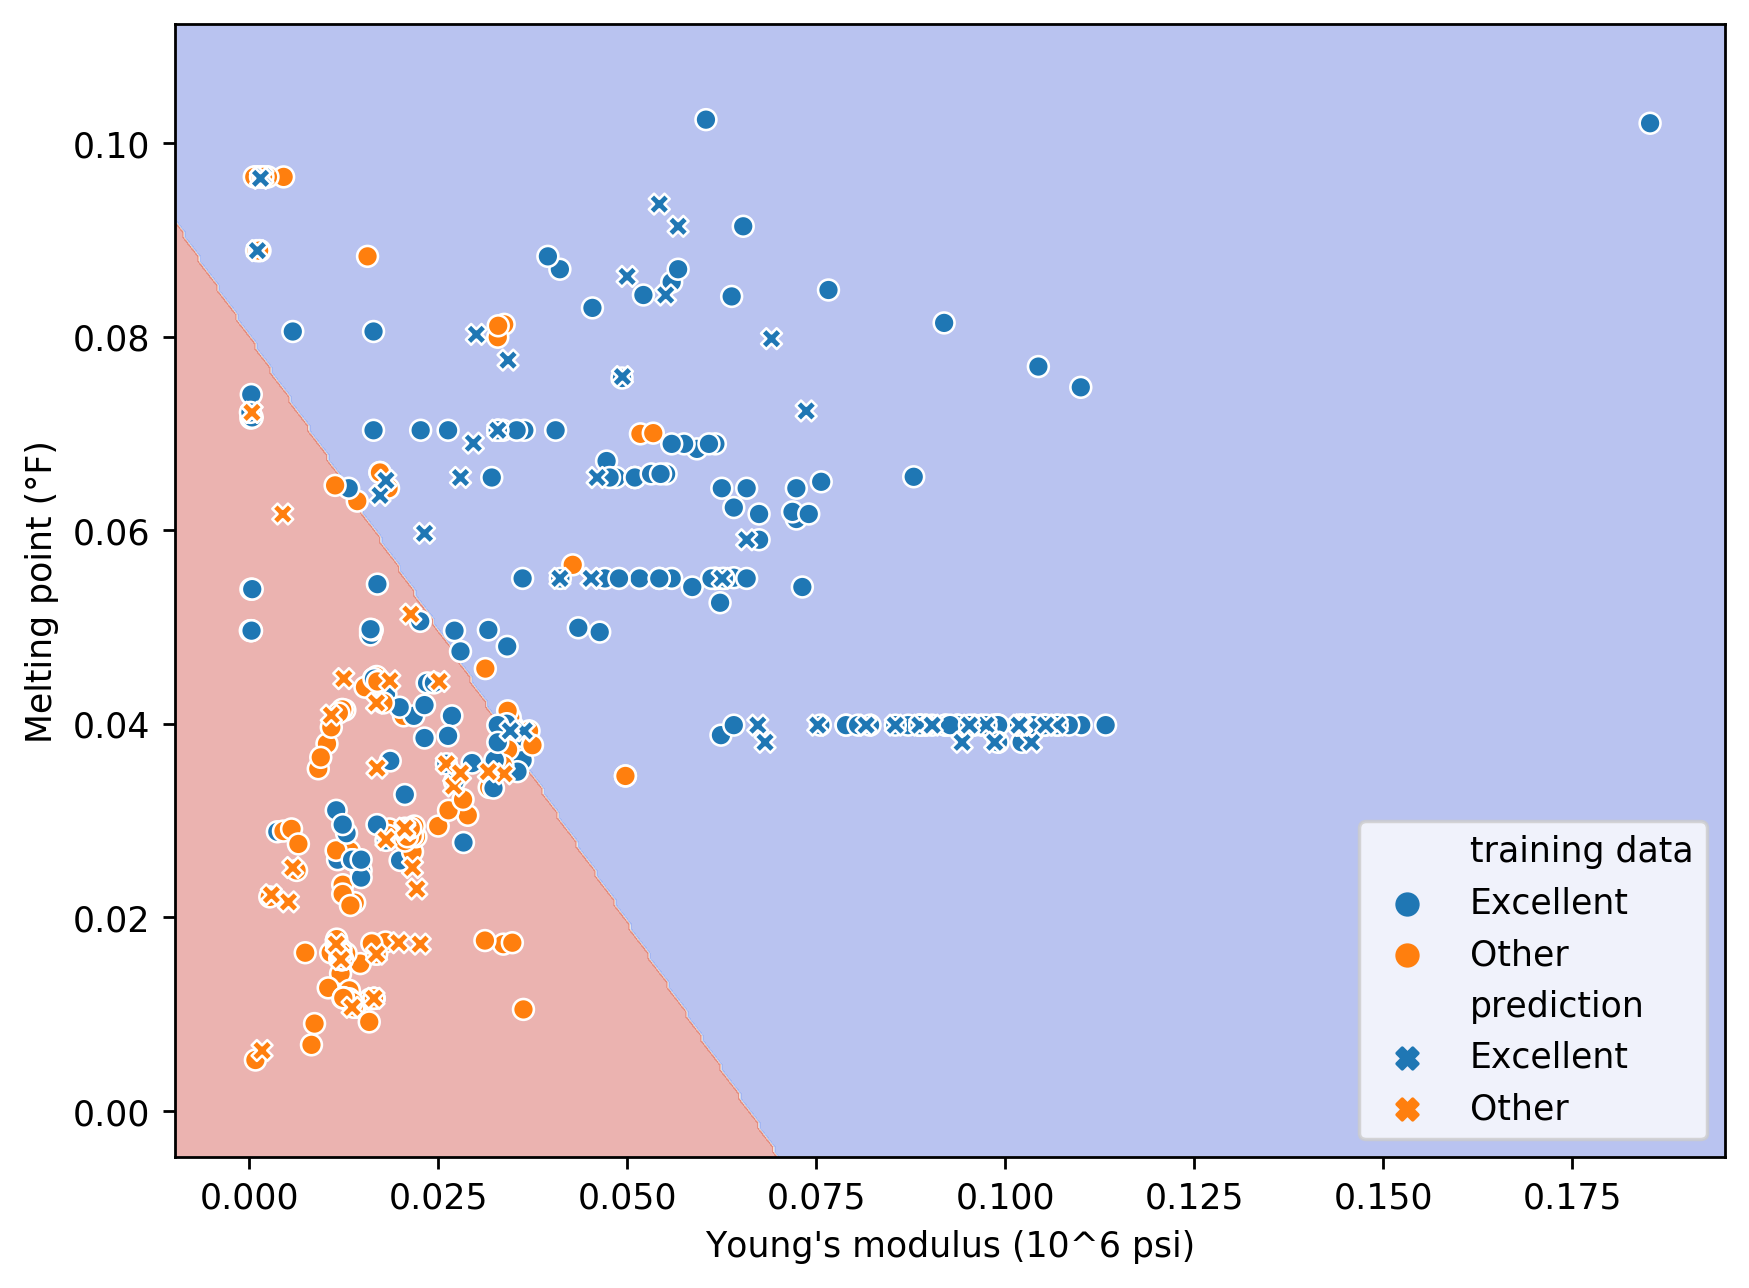

In [17]:
binarize = {'Excellent':0,'Other':1}

xx, yy = np.meshgrid(np.arange(min(x_trainsvm["Young's modulus (10^6 psi)"])-0.01, max(x_trainsvm["Young's modulus (10^6 psi)"])+0.01, 0.0005),
                     np.arange(min(x_trainsvm['Melting point (°F)'])-0.01, max(x_trainsvm['Melting point (°F)'])+0.01, 0.0005))
z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()]) 
z = pd.Series(z).map(binarize)
z = z.values.reshape(xx.shape)

plt.figure(figsize=(8,6),dpi=250)
plt.contourf(xx, yy, z, cmap=plt.cm.coolwarm, alpha=0.4)

svmpredict_results = x_testsvm.copy()
svmpredict_results['prediction'] = y_predictsvm
svmtrain_results = x_trainsvm.copy()
svmtrain_results["training data"] = y_trainsvm.values
sns.scatterplot("Young's modulus (10^6 psi)",'Melting point (°F)',data=svmtrain_results,
                hue='training data',hue_order=['Excellent','Other'])
sns.scatterplot("Young's modulus (10^6 psi)",'Melting point (°F)',data=svmpredict_results,
                hue='prediction',style='prediction',markers=['X']*2,
                hue_order=['Excellent','Other'])


### Exercise 4
How does the parameter `C` in `svm_model` affect the decision boundary? and how does the test error change accordingly? You can observe that by using the above code to generate the results with different `C`. (Note that `C` is defined to be a positive value)

The larger the value of the C parameter, the smaller your margin will be of your hyperplane (line in 2D data) in the training data. You would think this is good since it means you have decreased misclassification of the data however you are decreasing the margins only on the training data which doesn't always reflect the entire data set, so sometimes you want to increase your margin so you are able to correctly classify more of your overall data while. It is like finding the goldilocks value of C that doesn't misclassify your data but also keeps a decent sized margin.

## Decision Trees

### Basic decision tree: binary tree

Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

Form training and validation data set:

In [18]:
x_dt = grantadata[["Young's modulus (10^6 psi)",'Melting point (°F)']].astype(float)
y_dt = grantadata['Oxidation at 500C']

x_traindt, x_testdt, y_traindt, y_testdt = train_test_split(x_dt,y_dt,test_size=0.2,random_state=10)

We bulid a decision tree using all x as predictors, and y as output.

In [19]:
DT = tree.DecisionTreeClassifier(max_depth=5)
DT.fit(x_traindt,y_traindt)

DecisionTreeClassifier(max_depth=5)

### Tree visualization and looking at the parity plot for individual instances

A simple way to plot the tree:

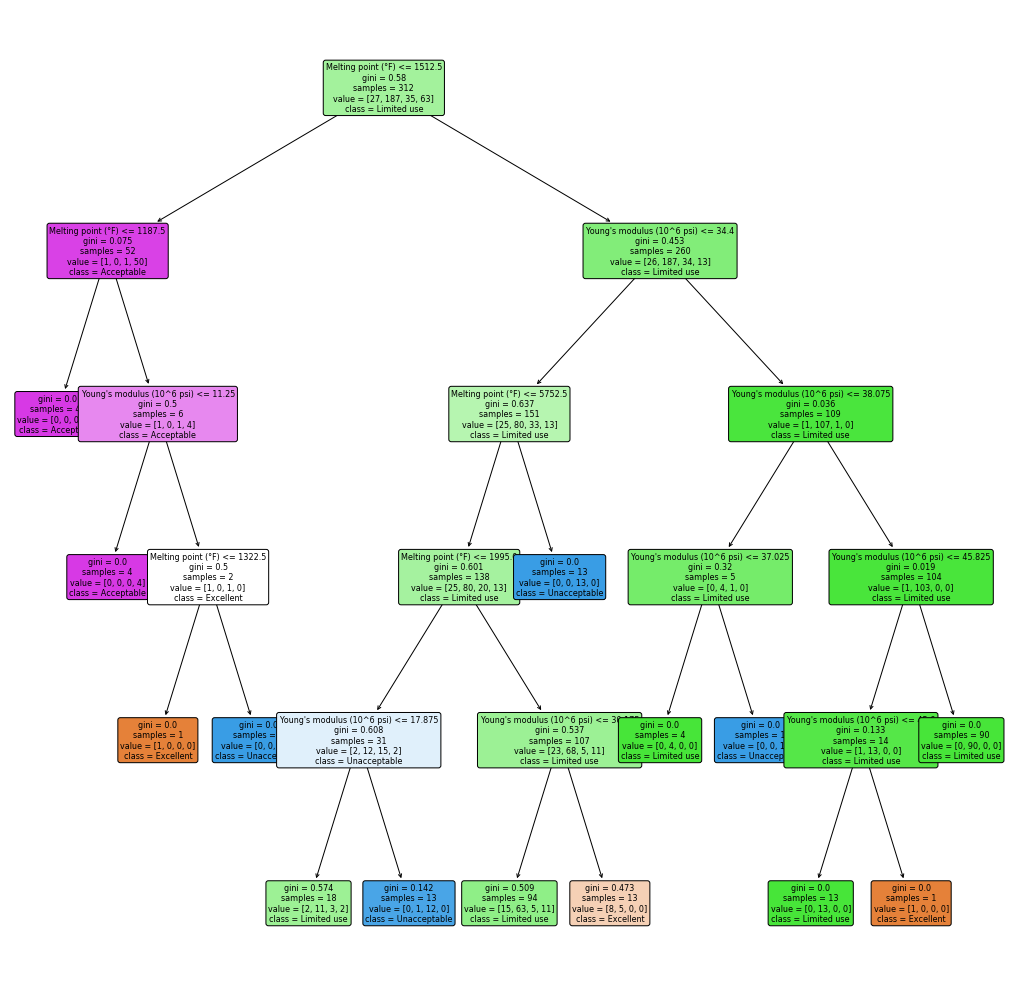

In [20]:
fig, ax = plt.subplots(figsize=(18,18))
tree.plot_tree(DT,fontsize=8,feature_names=["Young's modulus (10^6 psi)",'Melting point (°F)'],
               class_names=['Excellent', 'Limited use', 'Unacceptable','Acceptable'],
               filled=True,rounded=True)
plt.show()

#### Optioinal: Alternatively, we can use graphviz to export the tree. (Not installed on Jupyterhub. You can try this on your local computer. Also need to be installed if you haven't done so.)

In [21]:
#conda install python-graphviz

Note: we commented th code with graphviz because it might be problematic if you run it on jupyterhub.

In [22]:
#import os
#import graphviz

An example graphviz export of the above tree trained on the train dataset; the results are saved in an output file `granta_dt.pdf`. Please locate the file.

In [23]:
#dot_data = tree.export_graphviz(DT,out_file=None,feature_names=["Young's modulus (10^6 psi)",'Melting point (°F)'],
#                                class_names=['Excellent', 'Limited use', 'Unacceptable','Acceptable'],
#                                filled=True,rounded=True,special_characters=True)
#graph = graphviz.Source(dot_data) 
#graph.render("granta_dt")

Visualize the tree:

In [24]:
#graph

#### Make predictions on test and train set:

In [25]:
dt_trainpred=DT.predict(x_traindt)
dt_testpred=DT.predict(x_testdt)

Plot the training data and the testing data:

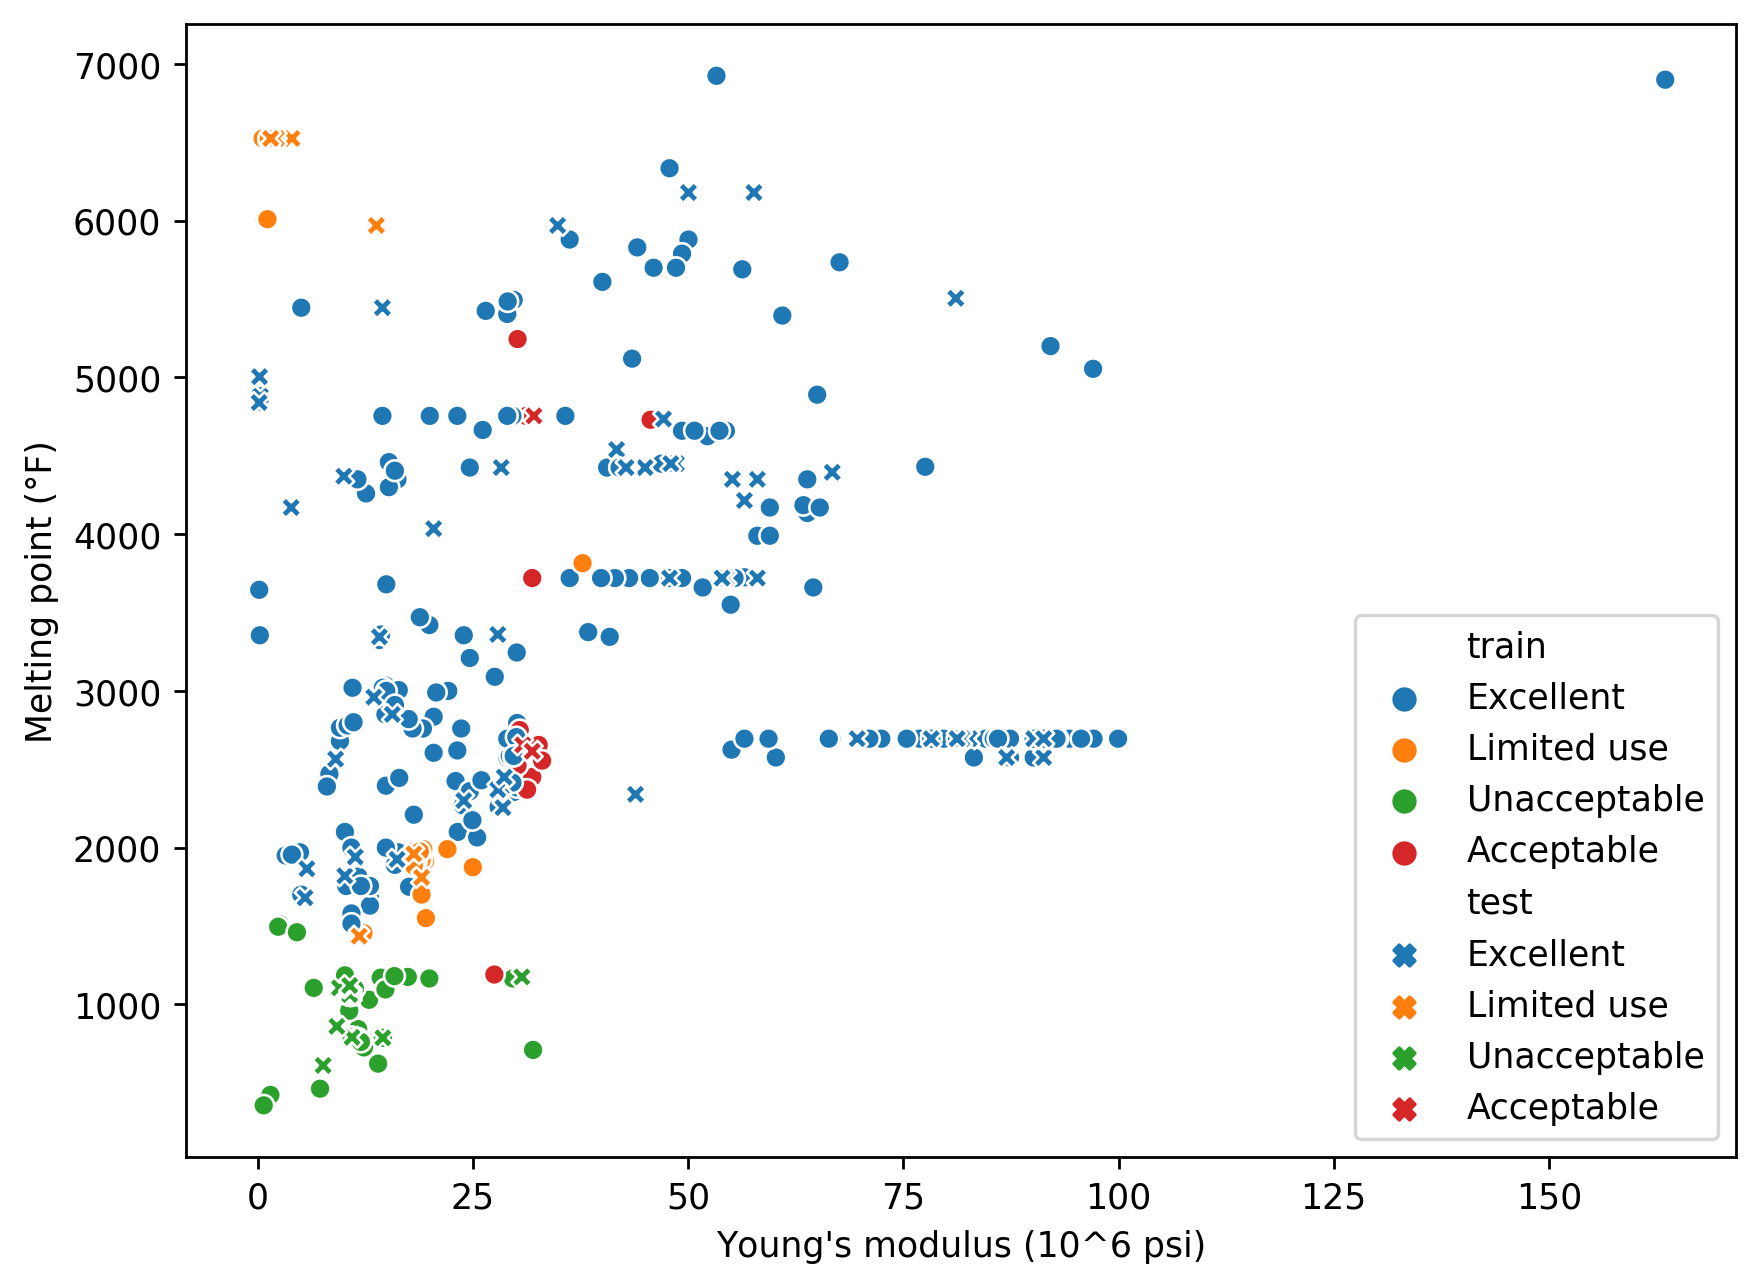

In [26]:
plt.figure(figsize=(8,6),dpi=250)

dttest_results = x_testdt.copy()
dttest_results['test'] = dt_testpred
dttrain_results = x_traindt.copy()
dttrain_results['train'] = dt_trainpred

sns.scatterplot("Young's modulus (10^6 psi)",'Melting point (°F)',data=dttrain_results,hue='train',
                hue_order=['Excellent', 'Limited use', 'Unacceptable','Acceptable'])

sns.scatterplot("Young's modulus (10^6 psi)",'Melting point (°F)',data=dttest_results,hue='test',style='test',
                markers=['X']*4,hue_order=['Excellent', 'Limited use','Unacceptable', 'Acceptable'])

plt.show()

Calculate the test and train accuracy:

In [27]:
print("Train accuracy", DT.score(x_traindt,y_traindt))
print("Test accuracy", DT.score(x_testdt,y_testdt))

Train accuracy 0.8589743589743589
Test accuracy 0.8076923076923077


Please play with the parameter `max_depth`.

### Test and training set error as a function of maximum tree depth

In [28]:
trainerror = []
testerror = []

trees = np.arange(1,20,1)

for t in trees:
    dt_model=tree.DecisionTreeClassifier(max_depth=t)
    dt_model.fit(x_traindt,y_traindt)
    trainerror.append(1-dt_model.score(x_traindt,y_traindt))
    testerror.append(1-dt_model.score(x_testdt,y_testdt))

Text(0, 0.5, 'error')

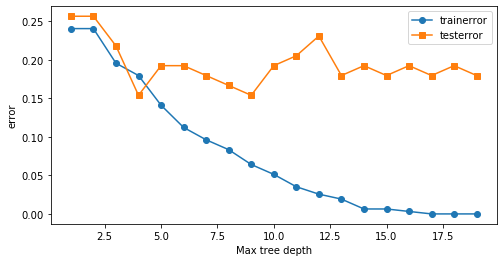

In [29]:
plt.figure(figsize=(8,4))
plt.plot(trees,trainerror,marker='o',label='trainerror')
plt.plot(trees,testerror,marker="s",label='testerror')
plt.legend()
plt.xlabel('Max tree depth')
plt.ylabel('error')

### Evaluate Decision Trees test error with K-fold cross-validation

In [30]:
fold = 5
kf_val = KFold(n_splits=fold,shuffle=True,random_state=10)
dt_scores = cross_val_score(DT,x_dt,y_dt,cv=kf_val)
dt_scores

array([0.80769231, 0.85897436, 0.83333333, 0.79487179, 0.83333333])

In [31]:
print("Mean error: ", 1-dt_scores.mean())

Mean error:  0.1743589743589744


### Exercise 5:
Please do a 10-fold cross-validation on Decision Trees model with maximum tree depth varying from 1 to 15. Make a plot showing the training error (from train-test splitting) and test error (from train-test splitting and K-fold cross-validation) as a function of maximum tree depth.

In [32]:
k = 10
kf_valid = KFold(n_splits = k, shuffle = True, random_state = 45)
trainerror=[]
#Train Test Splitting Error
testerror1=[]
#K-Fold Cross Val Error
testerror2=[]

trees = np.arange(1,16,1)

for i in trees:
    dt_model=tree.DecisionTreeClassifier(max_depth=i)
    dt_model.fit(x_traindt,y_traindt)
    trainerror.append(1-dt_model.score(x_traindt,y_traindt))
    testerror1.append(1-dt_model.score(x_testdt,y_testdt))
    testerror2.append(1-cross_val_score(dt_model,x_dt,y_dt,cv=kf_valid).mean())

Text(0.5, 0, 'Maximum Tree Depth')

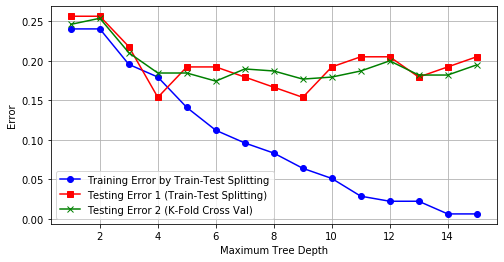

In [33]:
plt.figure(figsize=(8,4))
plt.plot(trees,trainerror, c='b',marker='o',label='Training Error by Train-Test Splitting')
plt.plot(trees,testerror1, c='r',marker='s',label='Testing Error 1 (Train-Test Splitting)')
plt.plot(trees,testerror2, c='g',marker='x',label='Testing Error 2 (K-Fold Cross Val)')
plt.legend(loc='lower left')
plt.grid()
plt.ylabel('Error')
plt.xlabel('Maximum Tree Depth')